In [47]:
# pip install tabulate
import io, requests, glob, os
import requests
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL


In [48]:
def plot_param(params, title, data):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [49]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)
with open("timeline-faelle-bundeslaender.csv", "wb") as f:
    f.write(req.content)

data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

data["TestungenPCRTaeglich"] = data["TestungenPCR"].diff(periods=10)
data["HospitalisierungTaeglich"] = data["Hospitalisierung"].diff(periods=10)
data["Neuinfektionen"] = data["BestaetigteFaelleBundeslaender"].diff(
    periods=10)
data["Positivrate"] = data.apply(lambda row: np.nan if row["TestungenPCRTaeglich"] == 0 else row["Neuinfektionen"] * 100000 / row["TestungenPCRTaeglich"], axis=1)
data["Datum"] = pd.to_datetime(data["Datum"], utc=True).dt.date + pd.DateOffset(days=-1)
for bl in data["Name"].unique():
    for param in ["TestungenPCRTaeglich", "HospitalisierungTaeglich", "Hospitalisierung", "Neuinfektionen", "Positivrate"]:
        mean = data.loc[data["Name"] == bl, param].mean()
        stdev = data.loc[data["Name"] == bl, param].std()
        minVal = 0 if (param == "TestungenPCRTaeglich" or param ==
                       "Neuinfektionen" or param == "Positivrate") else mean - 5 * stdev
        maxVal = mean + 5 * stdev
        data.loc[(data["Name"] == bl) & ((data[param] < minVal)
                                         | (data[param] > maxVal)), param] = np.nan
        data.loc[data["Name"] == bl, param] = data.loc[data["Name"]
                                                       == bl, param].fillna(method="bfill")
        data.loc[data["Name"] == bl, param] = data.loc[data["Name"]
                                                       == bl, param].fillna(method="ffill")
data.to_csv("timeline-faelle-bundeslaender.csv", encoding='utf-8', index=False)


In [50]:
data = pd.read_csv("timeline-faelle-bundeslaender.csv",
                   encoding='utf-8', parse_dates=[0])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)


## Hospitalisierung
### Werte der letzten 7 Tage

In [51]:
data.tail(7*10).pivot(values="Hospitalisierung", columns="Name").to_markdown()


'| Datum               |   Burgenland |   Kärnten |   Niederösterreich |   Oberösterreich |   Salzburg |   Steiermark |   Tirol |   Vorarlberg |   Wien |   Österreich |\n|:--------------------|-------------:|----------:|-------------------:|-----------------:|-----------:|-------------:|--------:|-------------:|-------:|-------------:|\n| 2022-01-02 00:00:00 |           49 |        89 |                178 |              104 |         43 |          123 |     120 |           40 |    271 |         1017 |\n| 2022-01-03 00:00:00 |           50 |        91 |                178 |              101 |         52 |          130 |     121 |           44 |    271 |         1038 |\n| 2022-01-04 00:00:00 |           50 |        87 |                168 |              103 |         55 |          122 |     122 |           39 |    264 |         1010 |\n| 2022-01-05 00:00:00 |           51 |        86 |                146 |               92 |         60 |          114 |     122 |           39 |    261 |  

### Diagramm

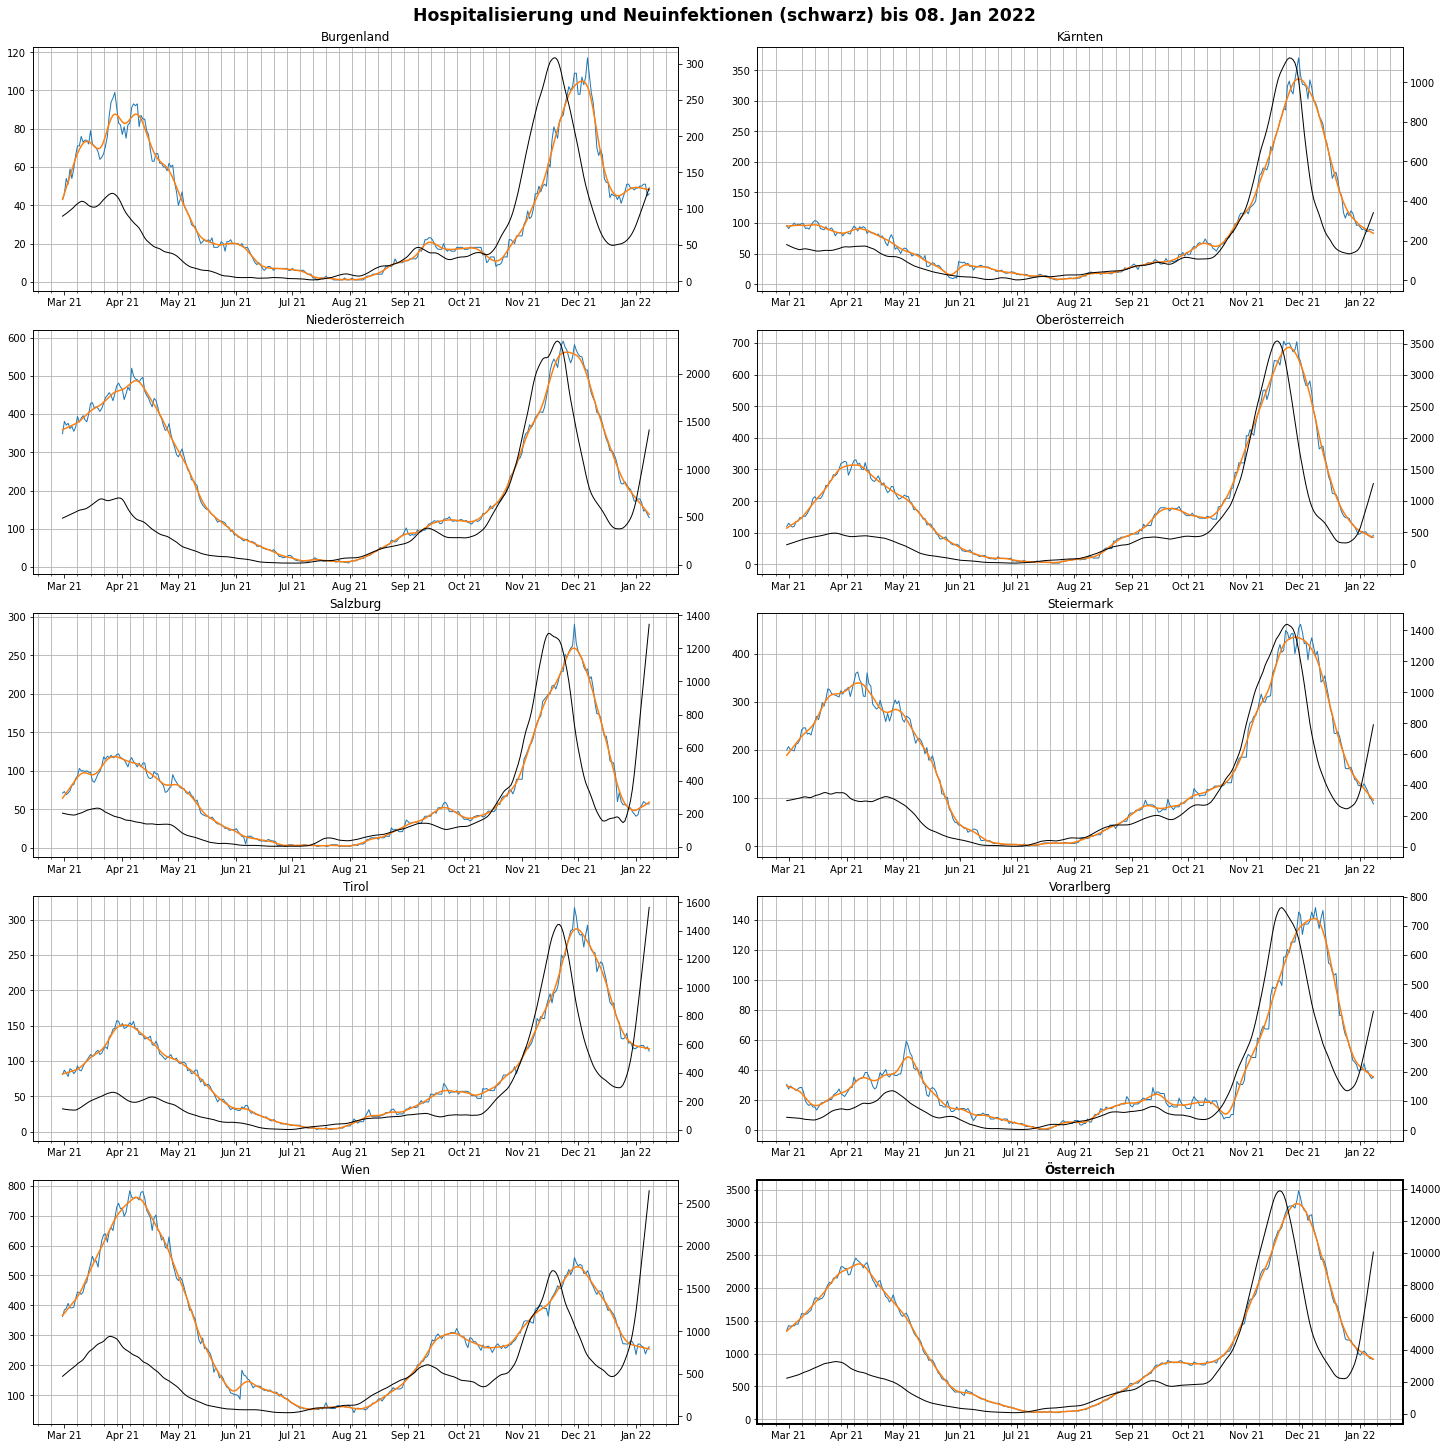

In [52]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [53]:
data.tail(7*10).pivot(values="TestungenPCRTaeglich", columns="Name").to_markdown()

'| Datum               |   Burgenland |   Kärnten |   Niederösterreich |   Oberösterreich |   Salzburg |   Steiermark |   Tirol |   Vorarlberg |   Wien |   Österreich |\n|:--------------------|-------------:|----------:|-------------------:|-----------------:|-----------:|-------------:|--------:|-------------:|-------:|-------------:|\n| 2022-01-02 00:00:00 |         3595 |      1425 |              16345 |            42097 |       1680 |         9544 |   10702 |         4554 |  77145 |       167087 |\n| 2022-01-03 00:00:00 |         2991 |      2164 |              16390 |            30941 |      10611 |        22146 |   19804 |         4209 | 125833 |       235089 |\n| 2022-01-04 00:00:00 |         6004 |      2996 |              17490 |            23385 |      21992 |        38605 |   15926 |         3702 | 162317 |       482714 |\n| 2022-01-05 00:00:00 |         7045 |     12112 |              16748 |            24347 |      17169 |        17646 |   20532 |         3702 | 153445 |  

### Diagramm

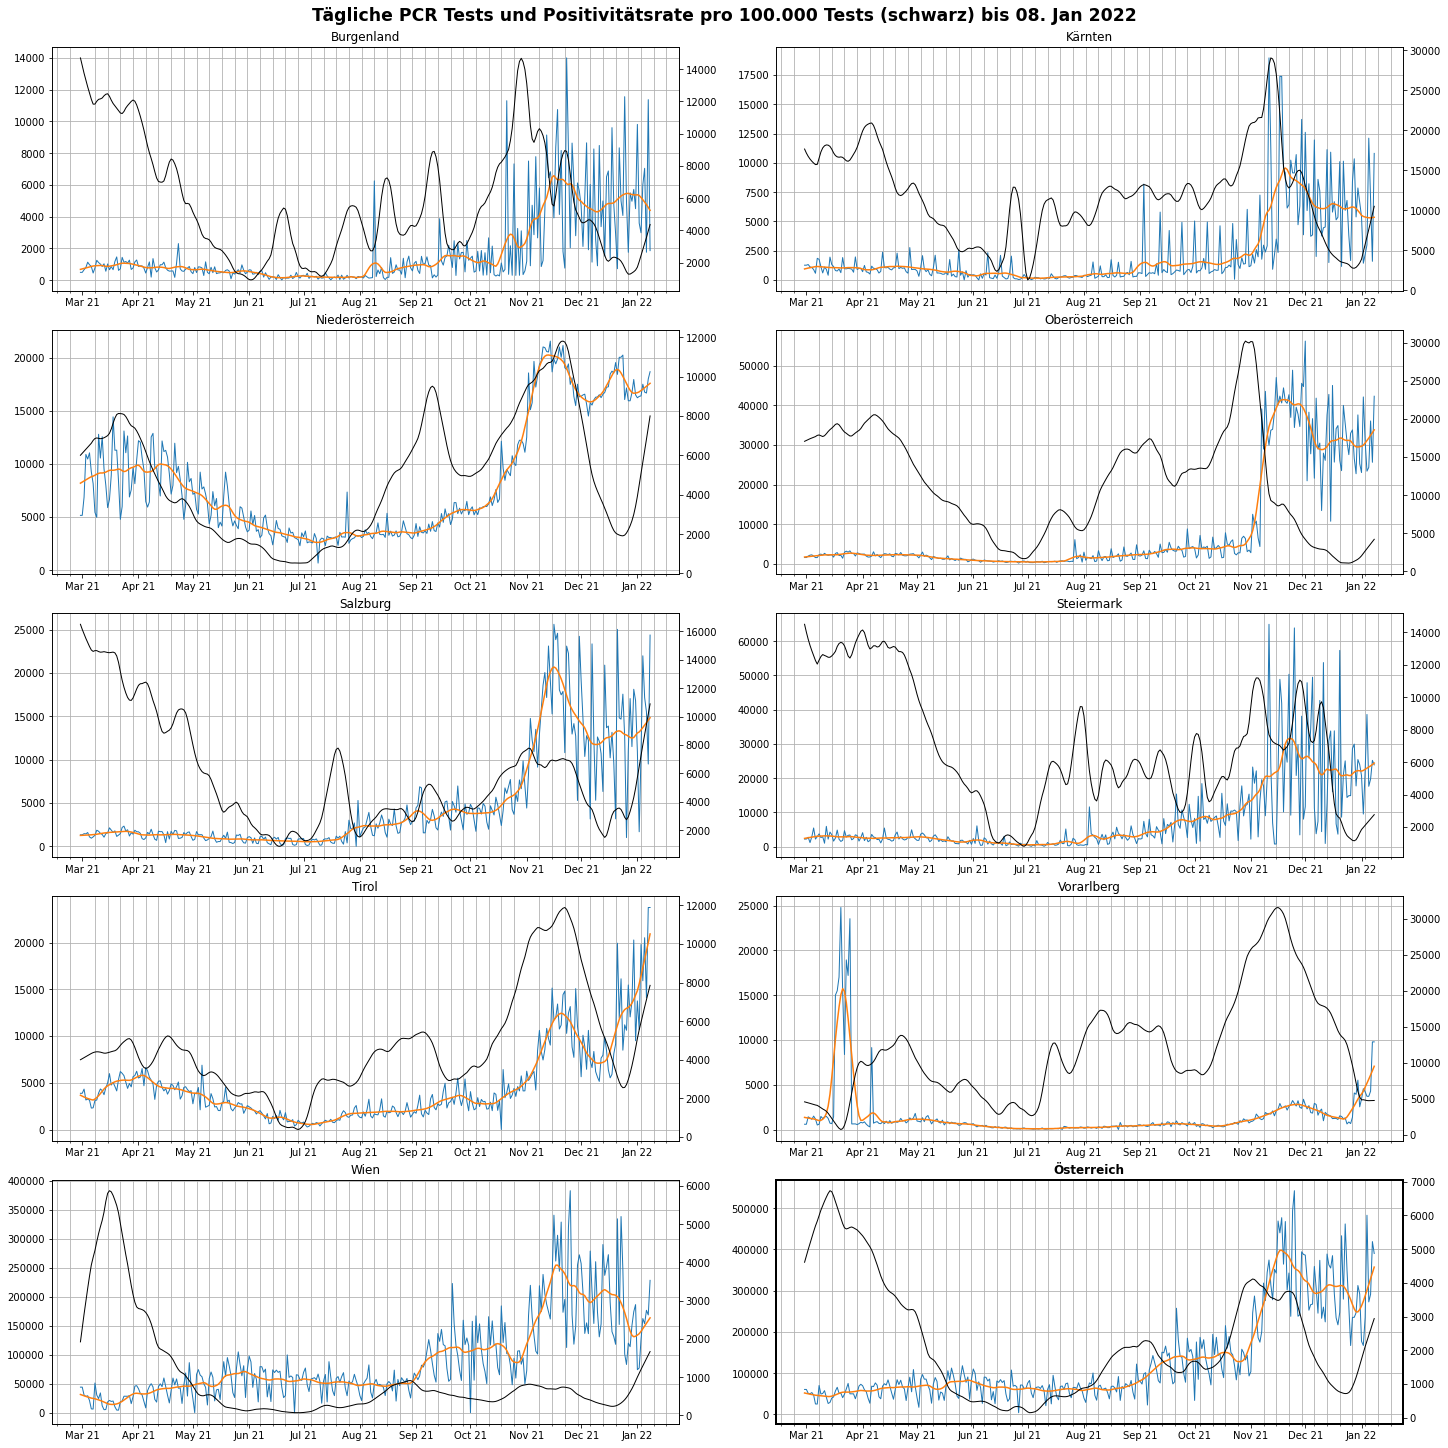

In [54]:

plot_param(["TestungenPCRTaeglich", "Positivrate"], "Tägliche PCR Tests und Positivitätsrate pro 100.000 Tests (schwarz)", data)
